# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np

import utils



def prepare_data():
    df = utils.load_data()
    ts, covars_diff, covars_nodiff = utils.df2ts(df)
    covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True)
    covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
        covars_nodiff, should_diff=False
    )
    pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True)

    train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
    train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

    covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled)
    train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
        pd.Timestamp("2016-01-01")
    )

    # Define the training and validation sets
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history, pipeline, ts_scaled, val_ts, covariates_scaled

# AR Model

In [2]:
train, validation, history, pipeline, ts_scaled, val_ts, _ = prepare_data()


<Axes: xlabel='DATE'>

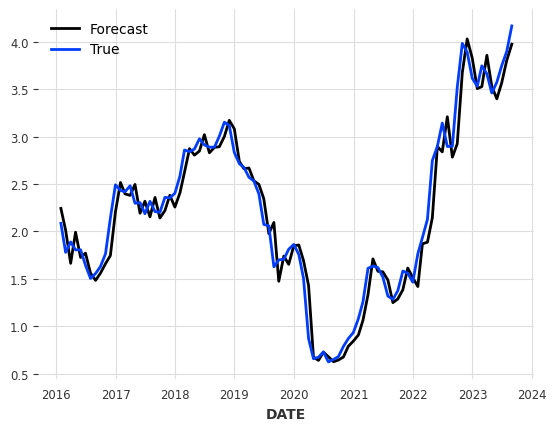

In [3]:
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Compute the optimal lag order on the training set
sel = ar_select_order(train, 12, old_names=False, glob=True)


# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

     # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month using the optimal lag order
    model = AutoReg(hist_t, lags=sel.ar_lags, old_names=False)
    model_fit = model.fit(cov_type="HC0")

    # Forecast for t + 1
    model_fit = model_fit.append(validation[t:t])
    y_pred = model_fit.get_prediction(start=-1)
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_dataframe(y_pred.summary_frame(), value_cols=["mean"]), pipeline, ts_scaled)
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})
    
    # print(y_pred.summary_frame())



    # Append the forecast to the list of forecasts
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

In [4]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      US_TB_YIELD_10YRS   No. Observations:                  523
Model:             Restr. AutoReg(12)   Log Likelihood                -650.336
Method:               Conditional MLE   S.D. of innovations              0.864
Date:                Sat, 04 Jan 2025   AIC                           1312.673
Time:                        20:41:10   BIC                           1338.091
Sample:                    02-28-1981   HQIC                          1322.638
                         - 08-31-2023                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0101      0.038     -0.265      0.791      -0.085       0.065
US_TB_YIELD_10YRS.L1      0.3248      0.069      4.733      0.000       0.190       0.459
US_TB_YIELD_10YRS.L2     -0.1407      0.060     -2.351      0.019      -0.258      -0.023
US_TB_YIELD_10YRS.L11     0.1051      0.069      1.524      0.128      -0.030       0.240
US_TB_YIELD_10YRS.L12    -0.1222      0.064     -1.898      0.058      -0.248       0.004
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1345           -0.3302j            1.1816           -0.4549
AR.2            -1.1345           +0.3302j            1.1816            0.4549
AR.3            -0.7782           -0.8782j            1.1734           -0.3654
AR.4            -0.7782           +0.8782j            1.1734            0.3654
AR.5            -0.2033           -1.1434j            1.1614           -0.2780
AR.6            -0.2033           +1.1434j            1.1614            0.2780
AR.7             0.3988           -1.0922j            1.1628           -0.1943
AR.8             0.3988           +1.0922j            1.1628            0.1943
AR.9             0.9099           -0.7869j            1.2030           -0.1135
AR.10            0.9099           +0.7869j            1.2030            0.1135
AR.11            1.2373           -0.2862j            1.2700           -0.0362
AR.12            1.2373           +0.2862j            1.2700            0.0362
------------------------------------------------------------------------------

Parameters and standard errors were estimated using a different dataset and were then applied to this dataset.
"""

In [5]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 7.349459790629732
RMSE: 0.19062248752552483
R2: 0.9533422271706352


In [6]:
# fig = model_fit.plot_diagnostics(lags=24)

# VAR Model

In [7]:
## IGNORE BELOW: Poutine pour formater les données pour VAR

train, validation, history, pipeline, ts_scaled, val_ts, covariates_scaled = prepare_data()

# Only CPI seems to be significant
ONLY_CPI = True


# VAR only works with multivariate time series, so we add the covariates to the yield time series
if ONLY_CPI:
    ts_scaled = ts_scaled.stack(covariates_scaled["US_CPI"])
else:
    ts_scaled = ts_scaled.stack(covariates_scaled)


history = ts_scaled.pd_dataframe()
train = history[: pd.Timestamp("2016-01-01")]
validation = history[pd.Timestamp("2016-01-01") :]

<Axes: xlabel='DATE'>

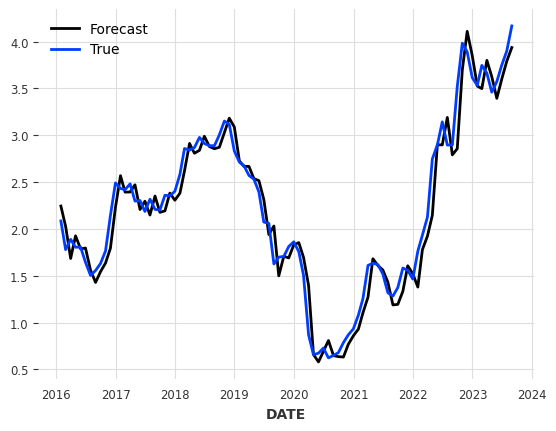

In [10]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit()

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=1)[0][0]
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_times_and_values(values=np.array([y_pred]), times=pd.DatetimeIndex([t], freq="ME")), pipeline, ts_scaled["US_TB_YIELD_10YRS"])
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})



    # print(y_pred.summary_frame())
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

In [11]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Jan, 2025
Time:                     20:43:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.811342
Nobs:                     521.000    HQIC:                 -0.841155
Log likelihood:          -1248.41    FPE:                   0.423013
AIC:                    -0.860352    Det(Omega_mle):        0.418183
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.011128         0.040675           -0.274           0.784
L1.US_TB_YIELD_10YRS         0.300414         0.040644            7.391           0.000
L1.US_CPI           

In [12]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 7.698402713219081
RMSE: 0.1921559061324272
R2: 0.9525885525630501


In [12]:
model_fit.test_normality()

In [13]:
model_fit.test_whiteness()

In [13]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.1678,3.850,0.682,"(1, 1036)"


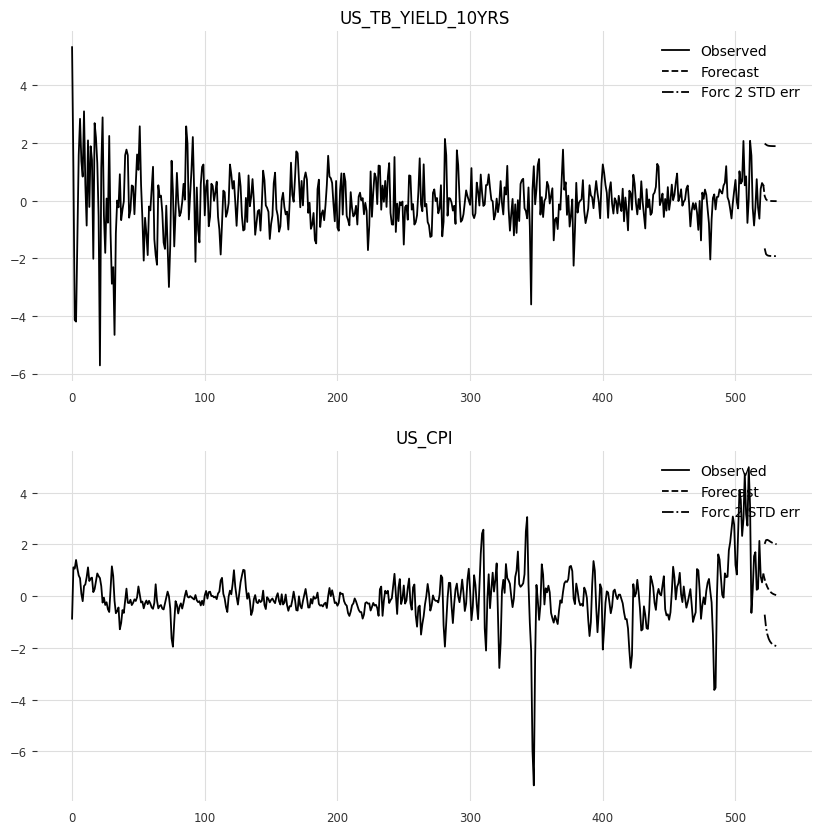

In [14]:
fig = model_fit.plot_forecast(10)